In [1]:

import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

import math
import astropy
print('astropy',astropy.__version__ )
from spectral_cube import SpectralCube      # This is a handy package for working with 3D data cubes
from spectral_cube import LazyMask
from astropy.coordinates import SkyCoord
from reproject import reproject_interp      
from reproject.mosaicking import find_optimal_celestial_wcs 
import regions
import reproject
print('reproject',reproject.__version__)
import spectral_cube
print('spectral_cube',spectral_cube.__version__)
import numpy as np                          
import pylab                                
import matplotlib 
import matplotlib.gridspec as gridspec                                                                                             
import scipy
import astropy.io.fits as fits                                                          
from astropy.wcs import WCS                 
from astropy import units as u              
import pyspeckit as psk   
import astrodendro
import matplotlib.colors as colors
from matplotlib import pyplot as plt
# Suppress warnings we don't care about:
import sys
import gc

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
%matplotlib inline
from astrodendro.analysis import PPVStatistic


print(astrodendro.__file__)

from matplotlib.patches import Ellipse
import copy
from tqdm import tqdm
import radio_beam

from scipy.optimize import curve_fit
from scipy.optimize import leastsq
#%matplotlib widget
from astropy.convolution import Gaussian1DKernel


#Create a function that uses the dendrogram input to calculate all the quantities, and has the size and linewidth requirements of the Shetty paper
#Requires the computed dendrogram, the data from the line image, the velocity axis, and the data from the Continuum image, as well as metadata for the structures
#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]
#Continuum is in Jansky/Beam, Line data should have the unit specified in the metadata as 'data_unit'

def Dendro_Arrays(Dendrogram,LineData,DataVel,ContData,metadata,ColD = True):
    SizeA,SigmaA,LuminA,CDA,SIDS,MOM0_FLUX,Distances = [[],[],[],[]],[[],[],[],[]],[[],[]],[[],[]],[[],[]],[[],[]],[[],[]]
    print(metadata)
    center = SkyCoord('-00d03m20.76s  ', '-00d02m46.176s', frame='galactic')
    center_ra_pix,center_dec_pix = int(metadata['wcsu'][:][:][0].world_to_pixel(center)[0]),int(metadata['wcsu'][:][:][0].world_to_pixel(center)[1])
    
    sliced= LineData[12]
    CubeShape = np.shape(sliced)
    DataShape=[[0,0],[0,0]]#The part of the cube that actually has data
    for lmi in range(CubeShape[0]):
        allData=np.nansum(sliced[lmi])
        if(allData>0 or allData<0):
            DataShape[0][0] = lmi+3
            break
    for lmi in range(CubeShape[0]):
        allData=np.nansum(sliced[CubeShape[0] - lmi -1])
        if(allData>0 or allData<0):
            DataShape[0][1] = CubeShape[0] - lmi -3
            break
    for lmi in range(CubeShape[1]):
        allData=(sliced[DataShape[0][0],lmi])
        if(allData>0 or allData<0):
            DataShape[1][0] = lmi+3
            break
    for lmi in range(CubeShape[1]):
        allData=(sliced[DataShape[0][0],CubeShape[1] - lmi -1])
        if(allData>0 or allData<0):
            DataShape[1][1] = CubeShape[1] - lmi -3
            break
    print(DataShape,CubeShape)
    for t in Dendrogram.all_structures: 

        I = t.indices()
        Cont = True
        if t.is_branch:
                if t.parent==None:
                    Cont=True
                else:
                    Cont = True
        
        for lmi in range(len(I[0])):
            if(I[1][lmi]<=DataShape[0][0] or I[1][lmi]>=DataShape[0][1] or I[2][lmi]<=DataShape[1][0] or I[2][lmi]>=DataShape[1][1]):
                #print(I[1][lmi],I[0][lmi])
                Cont=False


            
        if(Cont):
            s = PPVStatistic(t,metadata=metadata)
            if((float((s.radius*np.pi/180*8.178*10**-3/u.deg)))*10**6<18 and (float((s.radius*np.pi/180*8.178*10**-3/u.deg)))*10**6>.6 and (float(s.v_rms/u.km*u.s))>.01):
            #if((float((s.radius*np.pi/180*8.178*10**-3/u.deg)))*10**6<18 and (float((s.radius*np.pi/180*8.178*10**-3/u.deg)))*10**6>.9 and (float(s.v_rms/u.km*u.s))>.01):
            #if( (float((s.radius*np.pi/180*8.178*10**-3/u.deg)))*10**6>.6 and (float(s.v_rms/u.km*u.s))>.01):
            #?
            #if((float((s.radius*np.pi/180*8.178*10**-3/u.deg)))*10**6>.9 and (float(s.v_rms/u.km*u.s))>.01):

                nproj_pix=len(set(zip(*tuple(I[i] for i in [1,2]))))
                v_IWM = np.nansum(LineData[I]*(DataVel[I[0]])/u.km*u.s)/np.nansum(LineData[I])
                sig_Sh = np.sqrt(np.nansum(LineData[I]*((DataVel[I[0]])/u.km*u.s-v_IWM)**2)/np.nansum(LineData[I])) 

                #The flux from the continuum
                #Convert to Jansky from Jansky per beam:
                if(ColD ==True):
                    Cont_Flux=0

                    proj = tuple(set(zip(*tuple(I[i] for i in [1,2]))))
                    for lmi in range(len(proj)):

                        Cont_Flux+=ContData[proj[lmi]]
                    Cont_Flux=Cont_Flux/(metadata['beam_area_ratioc']*(2*np.sqrt(2*np.log(2))))*u.pix**2*u.beam/u.beam*u.Jy#SHould be input as Jansky /beam and will be converted to Jansky, then to unitless. The beam is changed from FWHM to Gaussian
                    Dust_Column = Flux_to_Mass(Cont_Flux)*Num_per_kg/((s.radius*np.pi/180*8.178*10**-3/u.deg)**2*(3.086*10**24)**2)/np.pi*(1.989*10**30*u.kg/u.M_sun)/u.kg
                else:
                    Dust_Column=0
                if(str(Dust_Column) == str(np.nan) or str(Dust_Column)==str(np.inf)):
                    Dust_Column=0
                lum = Flux_to_Lum(s.flux)
                s_flux = s.flux

                Index = tuple(I[i] for i in [0,1,2])
                K_Km_s_Flux=np.nansum(LineData[Index]*metadata["velocity_scale"])#Find the total flux from the structures in K km/s, assuming the input data is in K as it should be, 
                Distance = np.sqrt((float(s.x_cen/u.pix)-center_ra_pix)**2+(float(s.y_cen/u.pix)- center_dec_pix)**2)*metadata['spatial_scale']*np.pi/180*8.178*10**-3*10**6/u.deg#pc dist from barycenter
                if(t.is_leaf):

                    SizeA[0].append((float((s.radius*np.pi/180*8.178*10**-3/u.deg)))) #define size as astrodendro
                    SigmaA[0].append((float(s.v_rms/u.km*u.s)))#
                    CDA[0].append(float(Dust_Column))
                    LuminA[0].append(float(lum*u.Hz*u.s/u.erg))
                    SIDS[0].append(float(t.idx))
                    MOM0_FLUX[0].append(float(K_Km_s_Flux*u.s/u.km))
                    Distances[0].append(float(Distance))
                if(t.is_branch	):

                    SizeA[1].append((float((s.radius*np.pi/180*8.178*10**-3/u.deg)))) #define size as astrodendro
                    SigmaA[1].append((float(s.v_rms/u.km*u.s)))#
                    CDA[1].append(float(Dust_Column))
                    LuminA[1].append(float(lum*u.Hz*u.s/u.erg))
                    SIDS[1].append(float(t.idx))
                    MOM0_FLUX[1].append(float(K_Km_s_Flux*u.s/u.km))
                    Distances[1].append(float(Distance))
                    
    SizeA[0] = np.array(SizeA[0],dtype=type(1.))
    SizeA[1] = np.array(SizeA[1],dtype=type(1.))
    SizeA[2] = np.array(SizeA[2],dtype=type(1.))
    SizeA[3] = np.array(SizeA[3],dtype=type(1.))
    SigmaA[0] = np.array(SigmaA[0],dtype=type(1.))
    SigmaA[1] = np.array(SigmaA[1],dtype=type(1.))
    SigmaA[2] = np.array(SigmaA[2],dtype=type(1.))
    SigmaA[3] = np.array(SigmaA[3],dtype=type(1.))
    CDA[0] = np.array(CDA[0],dtype=type(1.))
    CDA[1] = np.array(CDA[1],dtype=type(1.))
    LuminA[0] = np.array(LuminA[0],dtype=type(1.))
    LuminA[1] = np.array(LuminA[1],dtype=type(1.))
    SIDS[0] = np.array(SIDS[0],dtype=type(1.))
    SIDS[1] = np.array(SIDS[1],dtype=type(1.))
    MOM0_FLUX[0] = np.array(MOM0_FLUX[0],dtype=type(1.))
    MOM0_FLUX[1] = np.array(MOM0_FLUX[1],dtype=type(1.))
    Distances[0] = np.array(Distances[0],dtype=type(1.))
    Distances[1] = np.array(Distances[1],dtype=type(1.))
    
    return np.array(SizeA),np.array(SigmaA),np.array(CDA),np.array(LuminA),np.array(SIDS),np.array(MOM0_FLUX),np.array(Distances)

#Make a function to make an image 

#Data to plot, minimum of color bar, maximum, WCS projection for coords, and position of the image in the larger figure
def Make_Plot(Name,Name2,Data,vmin,vmax,WCS,rows,columns,index,show):
    

    ax = pylab.subplot(rows,columns,index,projection=WCS) 
    RA = ax.coords[0]                                                                  # 
    Dec = ax.coords[1]
    im = pylab.imshow(Data,vmin=vmin,vmax=vmax,cmap='rainbow')
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
    pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
    pylab.ylabel('Declination',fontsize=20,labelpad=1)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
    cb=pylab.colorbar(im,fraction=0.1,pad=0.0)                                     
    cb.set_label(label=Name,fontsize=10,rotation=270,labelpad=20) 
    cb.ax.tick_params(which = 'major', labelsize = 10)   
    pylab.annotate(s=Name2,fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  
    if(show==True):
        pylab.show()
def Make_Plot_Anno(Name,Name2,Data,vmin,vmax,WCS,rows,columns,index,show,pos1,pos2):
    

    ax = pylab.subplot(rows,columns,index,projection=WCS) 
    RA = ax.coords[0]                                                                  # 
    Dec = ax.coords[1]
    im = pylab.imshow(Data,vmin=vmin,vmax=vmax,cmap='rainbow')
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
    pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
    pylab.ylabel('Declination',fontsize=20,labelpad=1)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
    cb=pylab.colorbar(im,fraction=.1,pad=0.0)                                     
    cb.set_label(label=Name,fontsize=10,rotation=270,labelpad=20) 
    cb.ax.tick_params(which = 'major', labelsize = 10)   
    pylab.annotate(s=Name2,fontsize=10,xy=(pos1,pos2),xycoords="axes fraction")  
    if(show==True):
        pylab.show()
        
        
#Put this up here for the column density map
def Flux_to_Mass(flux):
    J_to_e = 10**-23*u.erg/u.s/u.cm**2/u.Hz/u.Jy
    flux_erg = flux*J_to_e
    L = 4*np.pi*(8.178*10**-3*3.086*10**24)**2*flux_erg*u.cm**2 #Megaparsec is converted to cm
    
    
    a_850 = 6.7*10**19*u.erg/u.s/u.Hz/u.M_sun #6.7+-1.7
    
    M_mol = L/a_850#Just in Solar mass*1.989*10**30*u.kg/u.M_sun #Determines mass of the cont for 850 in kg
    return M_mol
def Flux_to_Lum(flux):
    J_to_e = 10**-23*u.erg/u.s/u.cm**2/u.Hz/u.Jy
    flux_erg = flux*J_to_e
    L = 4*np.pi*(8.178*10**-3*3.086*10**24)**2*flux_erg*u.cm**2 #Megaparsec is converted to cm
    
    return L


def Find_Pixel_D(flux,metadata,sub = "Nope"):
    center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
    
    x,y = [metadata["Cwcs"].world_to_pixel(center)[0],(metadata["Cwcs"].world_to_pixel(center)[1])]
    d0 = 8.178 *10**-3*u.Mpc #mpc
    D_Es = np.empty(np.shape(flux))
    for lmi in range(len(flux)):
        for lmj in range(len(flux[lmi])):
            #Find the distance to earth from every pixel
            D_Es[lmi][lmj] = np.sqrt(d0**2 + (d0*np.tan(u.rad*metadata['arc_per_pix']*(np.sqrt((lmj-x)**2+(lmi-y)**2))/3600*np.pi/180/u.arcsec*u.pix))**2 )/u.Mpc#Has to be unitless so it saves, so bring the unit back when it is loaded
            
    #print(D_Es)
    if(sub=="Nope"):
        np.save("Pixel_D",D_Es)
    else:
        np.save(sub,D_Es)

#path ="Noise_Matched_CMZ_CO_3_2_355_005.fits"
#cmz_cube=SpectralCube.read(path)
#Find_Pixel_D(cmz_cube.moment0().hdu.data,metadata)

#Return a cropped cube for some ra and dec, also crops the velocity axis if needed (0 for no crop)
def Crop(cube,WCS,Np1,Np2,BadVel,D2):
    NraDP1 = [int(WCS.world_to_pixel(Np1)[0]),int(WCS.world_to_pixel(Np1)[1])]
    NraDP2 = [int(WCS.world_to_pixel(Np2)[0]),int(WCS.world_to_pixel(Np2)[1])]
    if(D2==False):
        return cube[BadVel:np.shape(cube)[0]-BadVel,NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]]
    if(D2==True):
        return cube[NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]]
    
#Make_Plot("Tes","Test2",Q.moment0().hdu.data,0,0,Q.wcs[:][:][0],2,2,1,True)
#Make_Plot("Tes","Test2",Q.moment0().hdu.data,0,0,Q.wcs[:][:][0],2,2,2,True)

/home/ben/miniconda3/bin/python
3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)
astropy 5.1.dev153+gb740594dc
reproject 0.8
spectral_cube 0.6.1.dev22+g003ef16
/home/ben/.local/lib/python3.8/site-packages/astrodendro/__init__.py


# Part 8: Dendograms

In [18]:
Names=[1,2,3,4,5,6,7,8,9,10,11,12] #An array for the dendrogram names

CMZ_CO 3-2_Abs_New ['CMZ_HCOp 1-0_Abs_New', 'CMZ_HCN 1-0_Abs_New', 'CMZ_H13CN 1-0_Abs_New', 'CMZ_H13CO+ 1-0_Abs_New', 'CMZ_CO 3-2_Abs_New', 'CMZ_CO 3-2_Abs', 'CMZ_CO 3-2_Abs', 'CMZ_CO 3-2_Abs']
OG noise =  0.07832633494764583 K
Reduced noise =  0.07832633494764583 K
Manual Noise noise =  0.07832633494764583 K


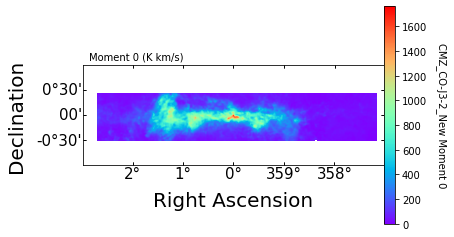

bp (2, 22948) (2, 339)


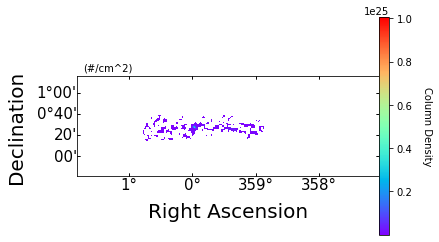

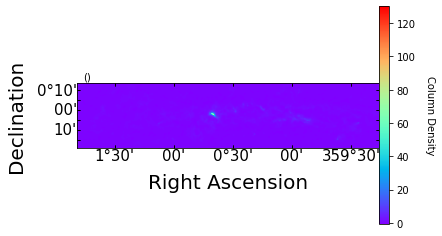

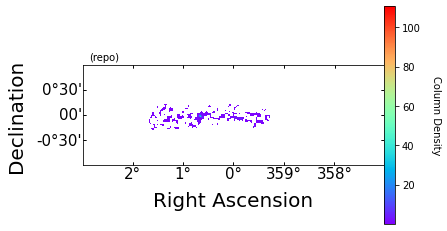

1.0038667675840004e+25 1 / cm2 t


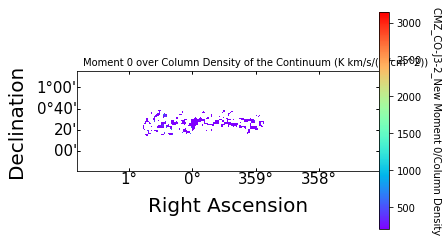

0.9230570099736797

3.600000000000063e-13 <class 'float'>
75.66573963576535 arcsec 75.66573963576535 arcsec
28.327249999999516 pix2
{'distance': <Quantity 0.008178 Mpc>, 'beam_area_ratioc': <Quantity 1.64292042 pix2>, 'wavelength': <Quantity 0.00086696 m>, 'data_unit': Unit("K"), 'arc_per_pix_y': <Quantity 15.13314793 arcsec / pix>, 'arc_per_pix_x': <Quantity 15.13314793 arcsec / pix>, 'beam_major': <Quantity 75.66573964 arcsec>, 'beam_minor': <Quantity 75.66573964 arcsec>, 'beam_area_ratio': <Quantity 28.32725 pix2>, 'spatial_scale': <Quantity 0.00420365 deg>, 'velocity_scale': <Quantity 2.5 km / s>, 'vaxis': 0, 'wcsu': WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-TAN'  'GLAT-TAN'  'VRAD'  
CRVAL : 3.0  -1.0  -249999.9999999952  
CRPIX : 0.0  0.0  -5.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.004203652201987  0.004203652201987  2500.0  
NAXIS : 1427  475  201}
[[112, 339], [63, 1390]] (475, 1427)


In [ ]:


#CO 
#
#
#For the cube that has not been rotated
#
#
Num=4
Ram_Limiter=1#What percent of the cube my ram can handle
#NGCCO32_Noise = 0.115*u.K
NGCCO32_Noise=0.6411655169449448*u.K

LineN="CMZ_CO-J3-2_New"
Name = "CMZ_CO 3-2_Abs_New"
name = "CMZ_CO_3_2_CM_Contours_Abs2_New.jpeg"
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2
Abs_Level="All"
try:
    Names= list(np.load("Names_CMZ_New.npy"))
except:
    Names= list(np.load("Names_CMZ.npy"))
Names[Num] = Name
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")

np.save("Names_CMZ_New",Names)

print(Name,Names)



#path ="Noise_Matched_CMZ_CO_3_2_355_005_New.fits"#"Noise_Matched_"+'CMZ_CO_3_2_358_002.fits'
path ="CMZ_CO_3_2_355_005_New.fits"#"Noise_Matched_"+'CMZ_CO_3_2_358_002.fits'

#path ='CMZ_CO_3_2_355_005_New.fits'
pathog='CMZ_CO_3_2_355_005_New.fits'
pathCont = 'CMZ_Continuum_Splice.fits'


#Make subcube

Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qp.allow_huge_operations=True
Qp = Qp[6:191,:,:]#Get rid of the excess nan parts
Q = Qp.to(u.K)#Jy to Kelvin

sc = Q.unmasked_copy()
Qpog = SpectralCube.read(pathog).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qpog.allow_huge_operations=True
Qpog = Qpog[6:191,:,:]#Get rid of the excess nan parts
Qog = Qpog.to(u.K)#Jy to Kelvin

scog = Qog.unmasked_copy()
Non_nan=((sc.hdu.data[0,:,:]>0)  | (sc.hdu.data[0,:,:]<0  ))

m = (np.nanstd(sc.hdu.data[0,:,:],where= Non_nan)) #Noise K
#m=.43
Non_nan=((scog.hdu.data[0,:,:]>0)  | (scog.hdu.data[0,:,:]<0 ))
mog = (np.nanstd(scog.hdu.data[0,:,:],where= Non_nan)) #Noise K
#m=.2
print("OG noise = ",mog,"K")

print("Reduced noise = ",m,"K")
print("Manual Noise noise = ",m,"K")
del scog
del Qog
del Qpog
scW = sc.wcs[:][:][0]
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scF = scn#[:,50:1300,50:1500]#Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
datn = dat#[:,50:1300,50:1500]#Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)z
#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Do the same thing to the continuum image
scCont.allow_huge_operations=True
scContW = scCont.reproject(scF.moment0().header)
#m=.115


#Put this up here for the column density map
metadata = {}
metadata["distance"] = 8.178*10**-3*u.Mpc
arc_per_pix_yc =  abs(scContW.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scContW.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scContW.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scContW.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratioc']=beam_area_ratioc
pc_per_pixelc = abs(scContW.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc







Continuum_Data  =scContW.hdu.data
scWCS = scF.wcs[:][:][0]

moment_0_sub  = scF.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 



######Moment 0 for both
######and cont
Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)


cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number

rm=moment_0_sub.hdu.data/cSD
rmU = rm*u.K*u.km/u.s#Just put back in the units
rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all

######ratio
   
bp = np.where(cSD<=.1*10**22/u.cm**2)
bp2 = np.where( moment_0_sub.hdu.data < .22)
print("bp",np.shape(bp),np.shape(bp2))
Continuum_Data[bp] = np.nan

cSD[bp]=np.nan
rmU[bp]=np.nan
rmU[bp2]=np.nan

Make_Plot("Column Density","(#/cm^2)",cSD,float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
Make_Plot("Column Density","()",scCont.hdu.data,float(np.nanmin(scCont.hdu.data)),float(np.nanmax(scCont.hdu.data)),scCont.wcs,1,1,1,True)
Make_Plot("Column Density","(repo)",scContW.hdu.data,float(np.nanmin(scContW.hdu.data)),float(np.nanmax(scContW.hdu.data)),scContW.wcs,1,1,1,True)
print(np.nanmax(cSD),'t')

Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)

print(np.nanmin(rmU))



header = scF.hdu.header
print()
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(1,freq,metadata['wavelength'])
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =scF[0][0][0].unit# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*(8.178*10**-3))**2#mpc^2/pix^2
print(area_res,type(area_res))

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s

metadata["vaxis"]=0
metadata["wcsu"]=scF.wcs

d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value) #The main culprit
#d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value*3) #The main culprit



vel,RA,Dec = scF.world[:,0,0]
Rads,Sigmas,CD,Lumin,SIDS,MOM0FLUX,Distances = Dendro_Arrays(d,datn,vel,Continuum_Data,metadata)
print(np.shape(Rads[0]),'rads')
print(np.shape(Sigmas[0]),"sigs")
print(np.shape(Rads[1]),'rads')
print(np.shape(Sigmas[1]),"sigs")
##Analyze dendograms





fig = plt.figure(1,figsize=(40,40))


axAlpha = pylab.subplot(5, 5, 7)
axBeta = pylab.subplot(5, 5, 8)
axGamma = pylab.subplot(5, 5, 9)
axDelta = pylab.subplot(5, 5, 10)




p1=d.plotter()
p1.plot_tree(axAlpha)
axAlpha.set_xlabel("Structure")
axAlpha.set_ylabel("Flux (K)")
axAlpha.set_title("Whole data set")



#Plot contours for the top ten clusters


#scCropped =scF.moment0().hdu.data
scCropped =scF.moment0().hdu.data
scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan

scCropped[bp]=np.nan
axDelta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
#axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
imBeta = axDelta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



ColumnCon= np.concatenate((CD[0],CD[1]))
SIDScon = np.concatenate((SIDS[0],SIDS[1]))
nth =0# sorted(CD[0])[len(CD[0])-20]

G1 = True

RA = axDelta.coords[0]                                                                  # 
Dec = axDelta.coords[1]

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
axDelta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.05),xycoords="axes fraction",c="black")  
pylab.annotate(s="Highest Density",fontsize=10,xy=(.31,1.05),xycoords="axes fraction",c="red")  

    


pc_per_pixel = abs(header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc

sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]


from scipy.optimize import curve_fit
from scipy.optimize import leastsq

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]


    
Rcon = np.concatenate((Rads[0],Rads[1]))


Scon = np.concatenate((Sigmas[0],Sigmas[1]))
Scon2 = np.concatenate((Sigmas[2],Sigmas[3]))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)









xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)

ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])


LuminCon = np.concatenate((Lumin[0],Lumin[1]))
ColumnCon= np.concatenate((CD[0],CD[1]))

MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
DistancesCon= np.concatenate((Distances[0],Distances[1]))
print(Distances)

#Radius Luminosity fit
#Good pixels are places where the luminosity and therefore column density are above zero
gp = np.where(LuminCon>0)
print(np.shape(Rcon),np.shape(LuminCon))
lgp = LuminCon[gp]
radgp = Rcon[gp]*10**6

gp2 = np.where(ColumnCon>0)
cgp = ColumnCon[gp2]
rgp=Scon[gp2]**2/Rcon[gp2]/10**6
dgp=DistancesCon[gp2]
radgpFORRAT = Rcon[gp2]*10**6
siggpFORRAT = Scon[gp2]
lumFORRAT = LuminCon[gp2]
mom0FORRAT = MOM0FLUXcon[gp2]

#print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))
RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
ysRL = func(xsRL,RLpopt[0],RLpopt[1])
#Column density to Size-linewidth
CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)

Dist_popt,Dist_pcov = curve_fit(func, np.array(DistancesCon,dtype='float64') ,np.array(Scon,dtype='float64'),maxfev=9999099,ftol = 10**-10)
Dist_popt2,Dist_pcov2 = curve_fit(func, np.array(dgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,ftol = 10**-10)

xsDist=np.linspace(np.nanmin(DistancesCon),np.nanmax(DistancesCon),50)
xsDist2=np.linspace(np.nanmin(dgp),np.nanmax(dgp),50)
ysDist=func(xsDist,Dist_popt[0],Dist_popt[1])
ysDist2=func(xsDist2,Dist_popt2[0],Dist_popt2[1])


axdis = pylab.subplot(5, 5, 12)
axdis2 = pylab.subplot(5, 5, 13)
axdis.scatter(DistancesCon,Scon)
axdis2.scatter(dgp,rgp)
axdis.plot(xsDist,ysDist)
axdis2.plot(xsDist2,ysDist2)
axdis2.set_yscale('log')
axdis2.set_xscale('log')
axdis.set_yscale('log')
axdis.set_xscale('log')

xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
ysCD = func(xsCD,CDpopt[0],CDpopt[1])


print(poptCon,pcovCon,"Size Linewidth All_structures:")
print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))


print(RLpopt,RLpcov,"Radius to Luminosity:")
print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))



print(CDpopt,CDpcov,"Column Density to linewidth^2/size:")
print("e = ",CDpopt[0],"+-",np.sqrt(CDpcov[0][0]))
print("f = ",CDpopt[1],"+-",np.sqrt(CDpcov[1][1]))



ax2 = pylab.subplot(5, 5, 1)
ax3 = pylab.subplot(5, 5, 2)
ax4 = pylab.subplot(5, 5, 3)

xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)


p = ax2.plot(xs,ysCon)





st="WDS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")

ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax2.set_xlabel("Size (pc)",fontsize=12)
ax2.set_ylabel("Sigma (km/s)",fontsize=12)
ax2.legend(prop={'size': 12},loc="upper right")
ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#gp = np.where(FRs>0)







xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)




ax4.set_yscale('log')
ax4.set_xscale('log')

ax4.set_xlabel("Radius (pc)",fontsize=12)
ax4.set_ylabel("sig (km/s)",fontsize=12)
ax4.legend(prop={'size': 12},loc="upper right")






xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)

ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax3.set_xlabel("Rad (pc)",fontsize=12)
ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax3.legend(prop={'size': 12})

gp3 = np.where(lumFORRAT>0)
lumFORRAT = lumFORRAT[gp3]
rgpFORRAT = rgp[gp3]
mom0FORRAT = mom0FORRAT[gp3]



ax5 = pylab.subplot(5, 5, 4)
ax6 = pylab.subplot(5, 5, 5)
ax7 = pylab.subplot(5, 5, 6)



xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures",s=30,alpha=.7)
ax5.set_yscale('log')
ax5.set_xscale('log')
ax5.set_xlabel("Size (pc)",fontsize=12)
ax5.set_ylabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
ax5.legend(prop={'size': 12},loc="upper right")




xspF2 = ax6.scatter(cgp,rgp,label="All_structures",s=30,alpha=.7)
pF2 = ax6.plot(xsCD,ysCD)

ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax6.set_xlabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax6.legend(prop={'size': 12},loc="upper right")
ax6.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
pFLLu2 = ax7.plot(xsRL,ysRL)

st = "WDS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.13),xycoords="axes fraction")
ax7.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")

ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax7.set_xlabel("Radius (pc)",fontsize=9)
ax7.set_ylabel("Luminosity (erg)",fontsize=9)
ax7.legend(prop={'size': 12},loc="upper right")
ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


axLam = pylab.subplot(5, 5, 11)
lum_rat = axLam.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axLam.set_yscale('log')
axLam.set_xscale('log')
axLam.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
axLam.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axLam.legend(prop={'size': 12},loc="upper right")
axLam.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



axDelta = pylab.subplot(5, 5, 10)




gp4=np.where(MOM0FLUXcon>0)
mom0FORFlux=MOM0FLUXcon[gp4]
radgpFORFlux=Rcon[gp4]*10**6
rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6

mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axDelta.set_yscale('log')
axDelta.set_xscale('log')
axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axDelta.legend(prop={'size': 12},loc="upper right")
axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


pylab.show()



NameCol = (Name+"_Column")
NameLum = (Name+"_Luminosities")

NameFlux = (Name+"Flux_Dense")
NameRFF = (Name+"Rad_For_Flux")





v1 = d.viewer()
v1.show()

#Must use text because np load is broken
Abs_Level="All"
if(Abs_Level=="All"):
    Suffix=''
if(Abs_Level=="None"):
    Suffix='_NA'
if(Abs_Level=="No Clusters"):
    Suffix='_No_Clusters'
np.savetxt(NameCol+"_Leaves"+Suffix, CD[0],fmt='%s')
np.savetxt(NameCol+"_Branches"+Suffix, CD[1],fmt='%s')

np.savetxt(NameLum+"_Leaves"+Suffix, Lumin[0],fmt='%s')
np.savetxt(NameLum+"_Branches"+Suffix, Lumin[1],fmt='%s')
np.savetxt(NameS+"_Leaves"+Suffix, Sigmas[0],fmt='%s')
np.savetxt(NameS+"_Branches"+Suffix, Sigmas[1],fmt='%s')
np.savetxt(NameR+"_Leaves"+Suffix, Rads[0],fmt='%s')
np.savetxt(NameR+"_Branches"+Suffix, Rads[1],fmt='%s')


np.savetxt(NameFlux+"_Leaves"+Suffix, MOM0FLUX[0],fmt='%s')
np.savetxt(NameFlux+"_Branches"+Suffix, MOM0FLUX[1],fmt='%s')



np.savetxt(NameCol+"_Leaves"+Suffix, CD[0],fmt='%s')
np.savetxt(NameCol+"_Branches"+Suffix, CD[1],fmt='%s')

np.savetxt(NameLum+"_Leaves"+Suffix, Lumin[0],fmt='%s')
np.savetxt(NameLum+"_Branches"+Suffix, Lumin[1],fmt='%s')
np.savetxt(NameS+"_Leaves"+Suffix, Sigmas[0],fmt='%s')
np.savetxt(NameS+"_Branches"+Suffix, Sigmas[1],fmt='%s')
np.savetxt(NameR+"_Leaves"+Suffix, Rads[0],fmt='%s')
np.savetxt(NameR+"_Branches"+Suffix, Rads[1],fmt='%s')
np.savetxt(Name+"Distances_Leaves"+Suffix, Distances[0],fmt='%s')
np.savetxt(Name+"Distances_Branches"+Suffix, Distances[1],fmt='%s')




SIDS=np.concatenate((SIDS[0],SIDS[1]))

print(SIDS[len(SIDS)-3:len(SIDS)-1])


CMZ_CO 3-2_Abs_New ['CMZ_HCOp 1-0_Abs_New', 'CMZ_HCN 1-0_Abs_New', 'CMZ_H13CN 1-0_Abs_New', 'CMZ_H13CO+ 1-0_Abs_New', 'CMZ_CO 3-2_Abs_New', 'CMZ_CO 3-2_Abs', 'CMZ_CO 3-2_Abs', 'CMZ_CO 3-2_Abs']
Noise (No abs) =  1.244657460287158 K


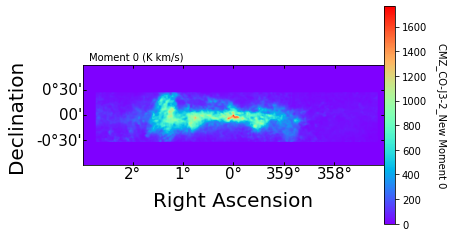

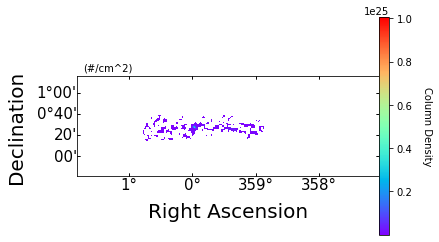

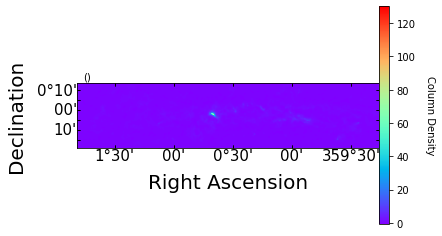

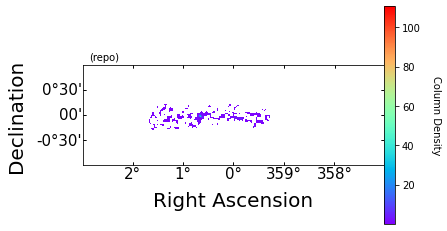

1.0038667675840004e+25 1 / cm2 t


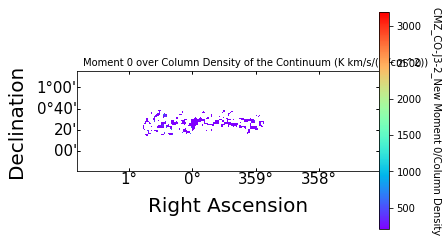


3.600000000000063e-13 <class 'float'>
75.66573963576535 arcsec 75.66573963576535 arcsec
28.327249999999516 pix2
{'distance': <Quantity 0.008178 Mpc>, 'beam_area_ratioc': <Quantity 1.64292042 pix2>, 'wavelength': <Quantity 0.00086696 m>, 'data_unit': Unit("K"), 'arc_per_pix_y': <Quantity 15.13314793 arcsec / pix>, 'arc_per_pix_x': <Quantity 15.13314793 arcsec / pix>, 'beam_major': <Quantity 75.66573964 arcsec>, 'beam_minor': <Quantity 75.66573964 arcsec>, 'beam_area_ratio': <Quantity 28.32725 pix2>, 'spatial_scale': <Quantity 0.00420365 deg>, 'velocity_scale': <Quantity 2.5 km / s>, 'vaxis': 0, 'wcsu': WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-TAN'  'GLAT-TAN'  'VRAD'  
CRVAL : 3.0  -1.0  -249999.9999999952  
CRPIX : 0.0  0.0  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.004203652201987  0.004203652201987  2500.0  
NAXIS : 1427  475  201}
(104,) rads
(104,) sigs
(67,) rads
(67,) sigs
185.41151095

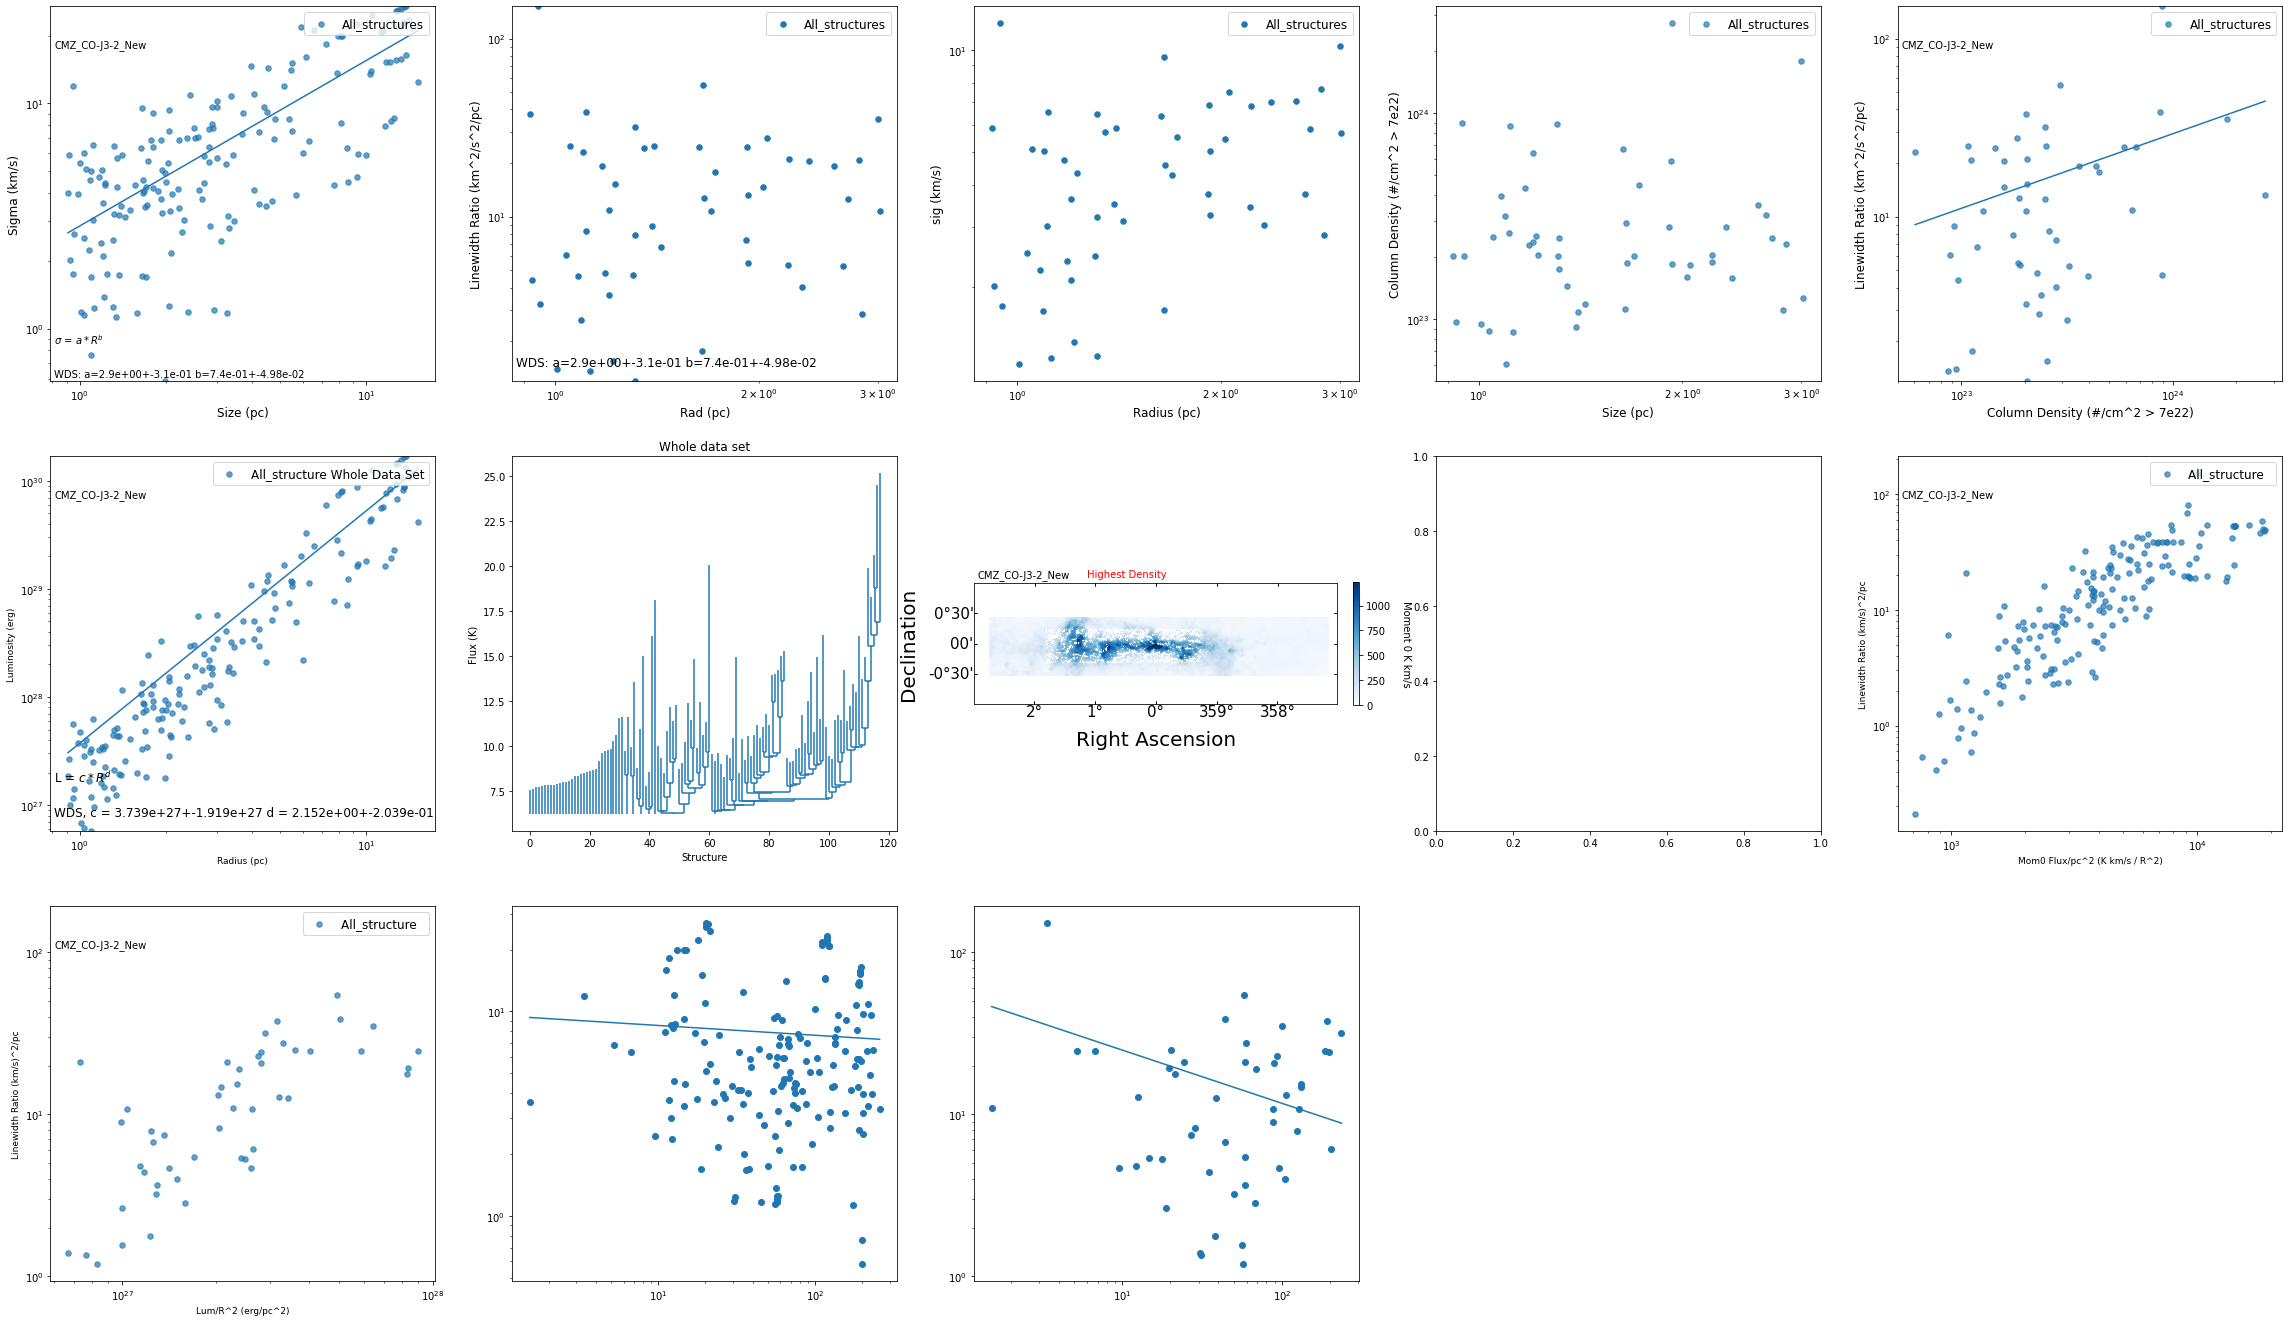

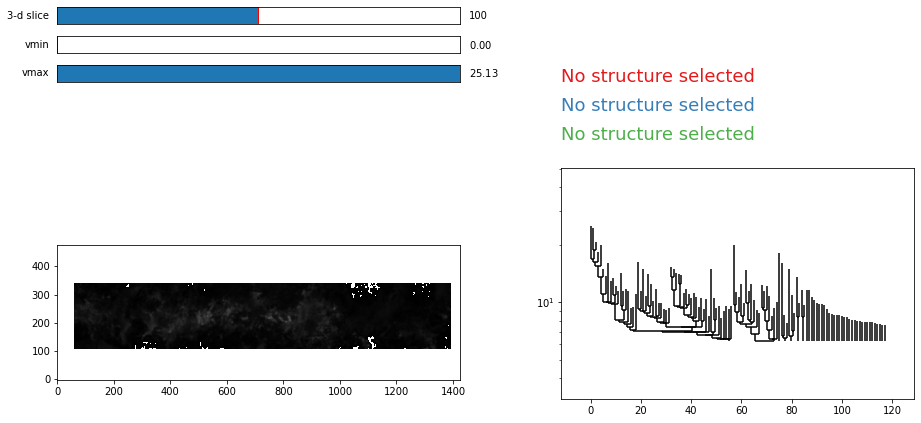

[165. 150.]


In [4]:


#CO 
#
#
#For the cube that has not been rotated
#
#
Num=4
Ram_Limiter=1#What percent of the cube my ram can handle
#NGCCO32_Noise = 0.115*u.K
NGCCO32_Noise=0.6411655169449448*u.K

LineN="CMZ_CO-J3-2_New"
Name = "CMZ_CO 3-2_Abs_New"
name = "CMZ_CO_3_2_CM_Contours_Abs2_New.jpeg"
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2
Abs_Level="None"
try:
    Names= list(np.load("Names_CMZ_New.npy"))
except:
    Names= list(np.load("Names_CMZ.npy"))
Names[Num] = Name
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")

np.save("Names_CMZ_New",Names)

print(Name,Names)



#path ="Noise_Matched_CMZ_CO_3_2_355_005_New.fits"#"Noise_Matched_"+'CMZ_CO_3_2_358_002.fits'
path ="CMZ_CO_3_2_355_005_New.fits"#"Noise_Matched_"+'CMZ_CO_3_2_358_002.fits'

#path ='CMZ_CO_3_2_355_005_New.fits'
pathog='CMZ_CO_3_2_355_005_New.fits'
pathCont = 'CMZ_Continuum_Splice.fits'


#Make subcube

Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qp.allow_huge_operations=True
Qp = Qp[:,:,:]#Get rid of the excess nan parts
Q = Qp.to(u.K)#Jy to Kelvin

sc = Q.unmasked_copy()
Qpog = SpectralCube.read(pathog).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qpog.allow_huge_operations=True
Qpog = Qpog[:,:,:]#Get rid of the excess nan parts
Qog = Qpog.to(u.K)#Jy to Kelvin

scog = Qog.unmasked_copy()

del scog
del Qog
del Qpog
scW = sc.wcs[:][:][0]
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scF = scn#[:,50:1300,50:1500]#Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
datn = dat#[:,50:1300,50:1500]#Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)z


bp = np.where(datn<0)
datn[bp]=np.nan

Non_nan=((datn>0)  | (datn<0 ))

m = (np.nanstd(datn,where= Non_nan)) #Noise K

print("Noise (No abs) = ",m,"K")


#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Do the same thing to the continuum image
scCont.allow_huge_operations=True
scContW = scCont.reproject(scF.moment0().header)
#m=.115


#Put this up here for the column density map
metadata = {}
metadata["distance"] = 8.178*10**-3*u.Mpc
arc_per_pix_yc =  abs(scContW.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scContW.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scContW.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scContW.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratioc']=beam_area_ratioc
pc_per_pixelc = abs(scContW.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc





Continuum_Data  =scContW.hdu.data
scWCS = scF.wcs[:][:][0]

moment_0_sub  = scF.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 



######Moment 0 for both
######and cont
Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)


cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number
rm=moment_0_sub.hdu.data/cSD
rmU = rm*u.K*u.km/u.s#Just put back in the units
rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all

######ratio
   
bp = np.where(cSD<=.1*10**22/u.cm**2)
bp2 = np.where( moment_0_sub.hdu.data < .22)

Continuum_Data[bp] = np.nan
cSD[bp]=np.nan
rmU[bp]=np.nan
rmU[bp2]=np.nan

Make_Plot("Column Density","(#/cm^2)",cSD,float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
Make_Plot("Column Density","()",scCont.hdu.data,float(np.nanmin(scCont.hdu.data)),float(np.nanmax(scCont.hdu.data)),scCont.wcs,1,1,1,True)
Make_Plot("Column Density","(repo)",scContW.hdu.data,float(np.nanmin(scContW.hdu.data)),float(np.nanmax(scContW.hdu.data)),scContW.wcs,1,1,1,True)
print(np.nanmax(cSD),'t')
#ggg = np.where(np.array(cSD*u.cm**2,dtype=type(1.0))!=np.nan)
#bgg = np.where(np.array(cSD*u.cm**2,dtype=type(1.0))==np.nan)

Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)





header = scF.hdu.header
print()
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(1,freq,metadata['wavelength'])
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =scF[0][0][0].unit# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*(8.178*10**-3))**2#mpc^2/pix^2
print(area_res,type(area_res))

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s

metadata["vaxis"]=0
metadata["wcsu"]=scF.wcs

d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value) #The main culprit
#d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value*3) #The main culprit



vel,RA,Dec = scF.world[:,0,0]
Rads,Sigmas,CD,Lumin,SIDS,MOM0FLUX,Distances = Dendro_Arrays(d,datn,vel,Continuum_Data,metadata)
print(np.shape(Rads[0]),'rads')
print(np.shape(Sigmas[0]),"sigs")
print(np.shape(Rads[1]),'rads')
print(np.shape(Sigmas[1]),"sigs")
##Analyze dendograms





fig = plt.figure(1,figsize=(40,40))


axAlpha = pylab.subplot(5, 5, 7)
axBeta = pylab.subplot(5, 5, 8)
axGamma = pylab.subplot(5, 5, 9)
axDelta = pylab.subplot(5, 5, 10)




p1=d.plotter()
p1.plot_tree(axAlpha)
axAlpha.set_xlabel("Structure")
axAlpha.set_ylabel("Flux (K)")
axAlpha.set_title("Whole data set")



#Plot contours for the top ten clusters


#scCropped =scF.moment0().hdu.data
scCropped =scF.moment0().hdu.data
scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan
print(np.nanmean(np.nanstd(scF.moment0().hdu.data))*1)
scCropped[bp]=np.nan
axDelta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
#axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
imBeta = axDelta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



ColumnCon= np.concatenate((CD[0],CD[1]))
SIDScon = np.concatenate((SIDS[0],SIDS[1]))
nth =0# sorted(CD[0])[len(CD[0])-20]

G1 = True

RA = axDelta.coords[0]                                                                  # 
Dec = axDelta.coords[1]

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
axDelta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.05),xycoords="axes fraction",c="black")  
pylab.annotate(s="Highest Density",fontsize=10,xy=(.31,1.05),xycoords="axes fraction",c="red")  

    


pc_per_pixel = abs(header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc

sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]


from scipy.optimize import curve_fit
from scipy.optimize import leastsq

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]


    
Rcon = np.concatenate((Rads[0],Rads[1]))


Scon = np.concatenate((Sigmas[0],Sigmas[1]))
Scon2 = np.concatenate((Sigmas[2],Sigmas[3]))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)









xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)

ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])


LuminCon = np.concatenate((Lumin[0],Lumin[1]))
ColumnCon= np.concatenate((CD[0],CD[1]))

MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
DistancesCon= np.concatenate((Distances[0],Distances[1]))


#Radius Luminosity fit
#Good pixels are places where the luminosity and therefore column density are above zero
gp = np.where(LuminCon>0)
print(np.shape(Rcon),np.shape(LuminCon))
lgp = LuminCon[gp]
radgp = Rcon[gp]*10**6

gp2 = np.where(ColumnCon>0)
cgp = ColumnCon[gp2]
rgp=Scon[gp2]**2/Rcon[gp2]/10**6
dgp=DistancesCon[gp2]
radgpFORRAT = Rcon[gp2]*10**6
siggpFORRAT = Scon[gp2]
lumFORRAT = LuminCon[gp2]
mom0FORRAT = MOM0FLUXcon[gp2]

#print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))
RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
ysRL = func(xsRL,RLpopt[0],RLpopt[1])
#Column density to Size-linewidth
CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)

Dist_popt,Dist_pcov = curve_fit(func, np.array(DistancesCon,dtype='float64') ,np.array(Scon,dtype='float64'),maxfev=9999099,ftol = 10**-10)
Dist_popt2,Dist_pcov2 = curve_fit(func, np.array(dgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,ftol = 10**-10)

xsDist=np.linspace(np.nanmin(DistancesCon),np.nanmax(DistancesCon),50)
xsDist2=np.linspace(np.nanmin(dgp),np.nanmax(dgp),50)
ysDist=func(xsDist,Dist_popt[0],Dist_popt[1])
ysDist2=func(xsDist2,Dist_popt2[0],Dist_popt2[1])


axdis = pylab.subplot(5, 5, 12)
axdis2 = pylab.subplot(5, 5, 13)
axdis.scatter(DistancesCon,Scon)
axdis2.scatter(dgp,rgp)
axdis.plot(xsDist,ysDist)
axdis2.plot(xsDist2,ysDist2)
axdis2.set_yscale('log')
axdis2.set_xscale('log')
axdis.set_yscale('log')
axdis.set_xscale('log')

xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
ysCD = func(xsCD,CDpopt[0],CDpopt[1])


print(poptCon,pcovCon,"Size Linewidth All_structures:")
print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))


print(RLpopt,RLpcov,"Radius to Luminosity:")
print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))



print(CDpopt,CDpcov,"Column Density to linewidth^2/size:")
print("e = ",CDpopt[0],"+-",np.sqrt(CDpcov[0][0]))
print("f = ",CDpopt[1],"+-",np.sqrt(CDpcov[1][1]))



ax2 = pylab.subplot(5, 5, 1)
ax3 = pylab.subplot(5, 5, 2)
ax4 = pylab.subplot(5, 5, 3)

xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)


p = ax2.plot(xs,ysCon)





st="WDS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")

ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax2.set_xlabel("Size (pc)",fontsize=12)
ax2.set_ylabel("Sigma (km/s)",fontsize=12)
ax2.legend(prop={'size': 12},loc="upper right")
ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#gp = np.where(FRs>0)







xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)




ax4.set_yscale('log')
ax4.set_xscale('log')

ax4.set_xlabel("Radius (pc)",fontsize=12)
ax4.set_ylabel("sig (km/s)",fontsize=12)
ax4.legend(prop={'size': 12},loc="upper right")






xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)

ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax3.set_xlabel("Rad (pc)",fontsize=12)
ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax3.legend(prop={'size': 12})

gp3 = np.where(lumFORRAT>0)
lumFORRAT = lumFORRAT[gp3]
rgpFORRAT = rgp[gp3]
mom0FORRAT = mom0FORRAT[gp3]



ax5 = pylab.subplot(5, 5, 4)
ax6 = pylab.subplot(5, 5, 5)
ax7 = pylab.subplot(5, 5, 6)



xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures",s=30,alpha=.7)
ax5.set_yscale('log')
ax5.set_xscale('log')
ax5.set_xlabel("Size (pc)",fontsize=12)
ax5.set_ylabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
ax5.legend(prop={'size': 12},loc="upper right")




xspF2 = ax6.scatter(cgp,rgp,label="All_structures",s=30,alpha=.7)
pF2 = ax6.plot(xsCD,ysCD)

ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax6.set_xlabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax6.legend(prop={'size': 12},loc="upper right")
ax6.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
pFLLu2 = ax7.plot(xsRL,ysRL)

st = "WDS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.13),xycoords="axes fraction")
ax7.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")

ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax7.set_xlabel("Radius (pc)",fontsize=9)
ax7.set_ylabel("Luminosity (erg)",fontsize=9)
ax7.legend(prop={'size': 12},loc="upper right")
ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


axLam = pylab.subplot(5, 5, 11)
lum_rat = axLam.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axLam.set_yscale('log')
axLam.set_xscale('log')
axLam.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
axLam.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axLam.legend(prop={'size': 12},loc="upper right")
axLam.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



axDelta = pylab.subplot(5, 5, 10)




gp4=np.where(MOM0FLUXcon>0)
mom0FORFlux=MOM0FLUXcon[gp4]
radgpFORFlux=Rcon[gp4]*10**6
rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6

mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axDelta.set_yscale('log')
axDelta.set_xscale('log')
axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axDelta.legend(prop={'size': 12},loc="upper right")
axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


pylab.show()



NameCol = (Name+"_Column")
NameLum = (Name+"_Luminosities")

NameFlux = (Name+"Flux_Dense_NA")
NameRFF = (Name+"Rad_For_Flux_NA")





v1 = d.viewer()
v1.show()
#Must use text because np load is broken
if(Abs_Level=="All"):
    Suffix=''
if(Abs_Level=="None"):
    Suffix='_NA'
if(Abs_Level=="No Clusters"):
    Suffix='_No_Clusters'
np.savetxt(NameCol+"_Leaves"+Suffix, CD[0],fmt='%s')
np.savetxt(NameCol+"_Branches"+Suffix, CD[1],fmt='%s')

np.savetxt(NameLum+"_Leaves"+Suffix, Lumin[0],fmt='%s')
np.savetxt(NameLum+"_Branches"+Suffix, Lumin[1],fmt='%s')
np.savetxt(NameS+"_Leaves"+Suffix, Sigmas[0],fmt='%s')
np.savetxt(NameS+"_Branches"+Suffix, Sigmas[1],fmt='%s')
np.savetxt(NameR+"_Leaves"+Suffix, Rads[0],fmt='%s')
np.savetxt(NameR+"_Branches"+Suffix, Rads[1],fmt='%s')


np.savetxt(NameFlux+"_Leaves"+Suffix, MOM0FLUX[0],fmt='%s')
np.savetxt(NameFlux+"_Branches"+Suffix, MOM0FLUX[1],fmt='%s')



np.savetxt(NameCol+"_Leaves"+Suffix, CD[0],fmt='%s')
np.savetxt(NameCol+"_Branches"+Suffix, CD[1],fmt='%s')

np.savetxt(NameLum+"_Leaves"+Suffix, Lumin[0],fmt='%s')
np.savetxt(NameLum+"_Branches"+Suffix, Lumin[1],fmt='%s')
np.savetxt(NameS+"_Leaves"+Suffix, Sigmas[0],fmt='%s')
np.savetxt(NameS+"_Branches"+Suffix, Sigmas[1],fmt='%s')
np.savetxt(NameR+"_Leaves"+Suffix, Rads[0],fmt='%s')
np.savetxt(NameR+"_Branches"+Suffix, Rads[1],fmt='%s')
np.savetxt(Name+"Distances_Leaves"+Suffix, Distances[0],fmt='%s')
np.savetxt(Name+"Distances_Branches"+Suffix, Distances[1],fmt='%s')




SIDS=np.concatenate((SIDS[0],SIDS[1]))

print(SIDS[len(SIDS)-3:len(SIDS)-1])


CMZ_CO 3-2_Abs_New ['CMZ_HCOp 1-0_Abs_New', 'CMZ_HCN 1-0_Abs_New', 'CMZ_H13CN 1-0_Abs_New', 'CMZ_H13CO+ 1-0_Abs_New', 'CMZ_CO 3-2_Abs_New', 'CMZ_CO 3-2_Abs', 'CMZ_CO 3-2_Abs', 'CMZ_CO 3-2_Abs']


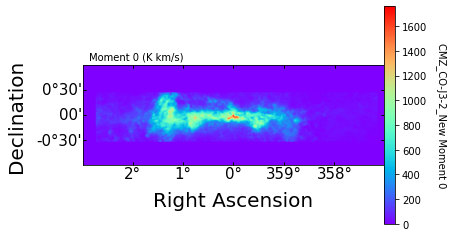

(475, 1427) (475, 1427) (201, 475, 1427)
Noise (No dense gas in the cont):  1.06305218154299


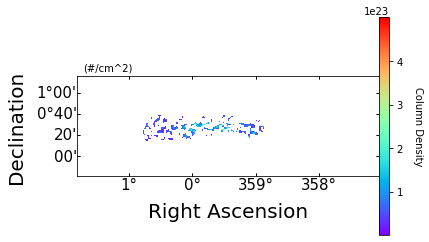

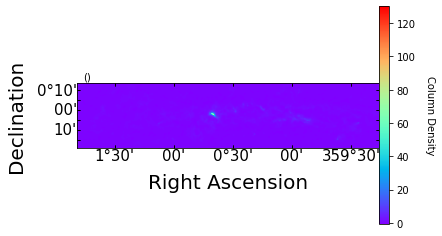

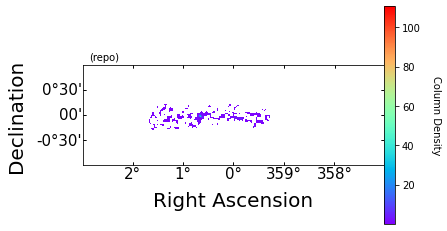

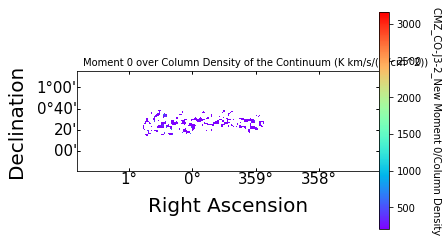


3.600000000000063e-13 <class 'float'>
75.66573963576535 arcsec 75.66573963576535 arcsec
28.327249999999516 pix2
{'distance': <Quantity 0.008178 Mpc>, 'beam_area_ratioc': <Quantity 1.64292042 pix2>, 'wavelength': <Quantity 0.00086696 m>, 'data_unit': Unit("K"), 'arc_per_pix_y': <Quantity 15.13314793 arcsec / pix>, 'arc_per_pix_x': <Quantity 15.13314793 arcsec / pix>, 'beam_major': <Quantity 75.66573964 arcsec>, 'beam_minor': <Quantity 75.66573964 arcsec>, 'beam_area_ratio': <Quantity 28.32725 pix2>, 'spatial_scale': <Quantity 0.00420365 deg>, 'velocity_scale': <Quantity 2.5 km / s>, 'vaxis': 0, 'wcsu': WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-TAN'  'GLAT-TAN'  'VRAD'  
CRVAL : 3.0  -1.0  -249999.9999999952  
CRPIX : 0.0  0.0  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.004203652201987  0.004203652201987  2500.0  
NAXIS : 1427  475  201}
(140,) rads
(140,) sigs
(91,) rads
(91,) sigs
183.84834554

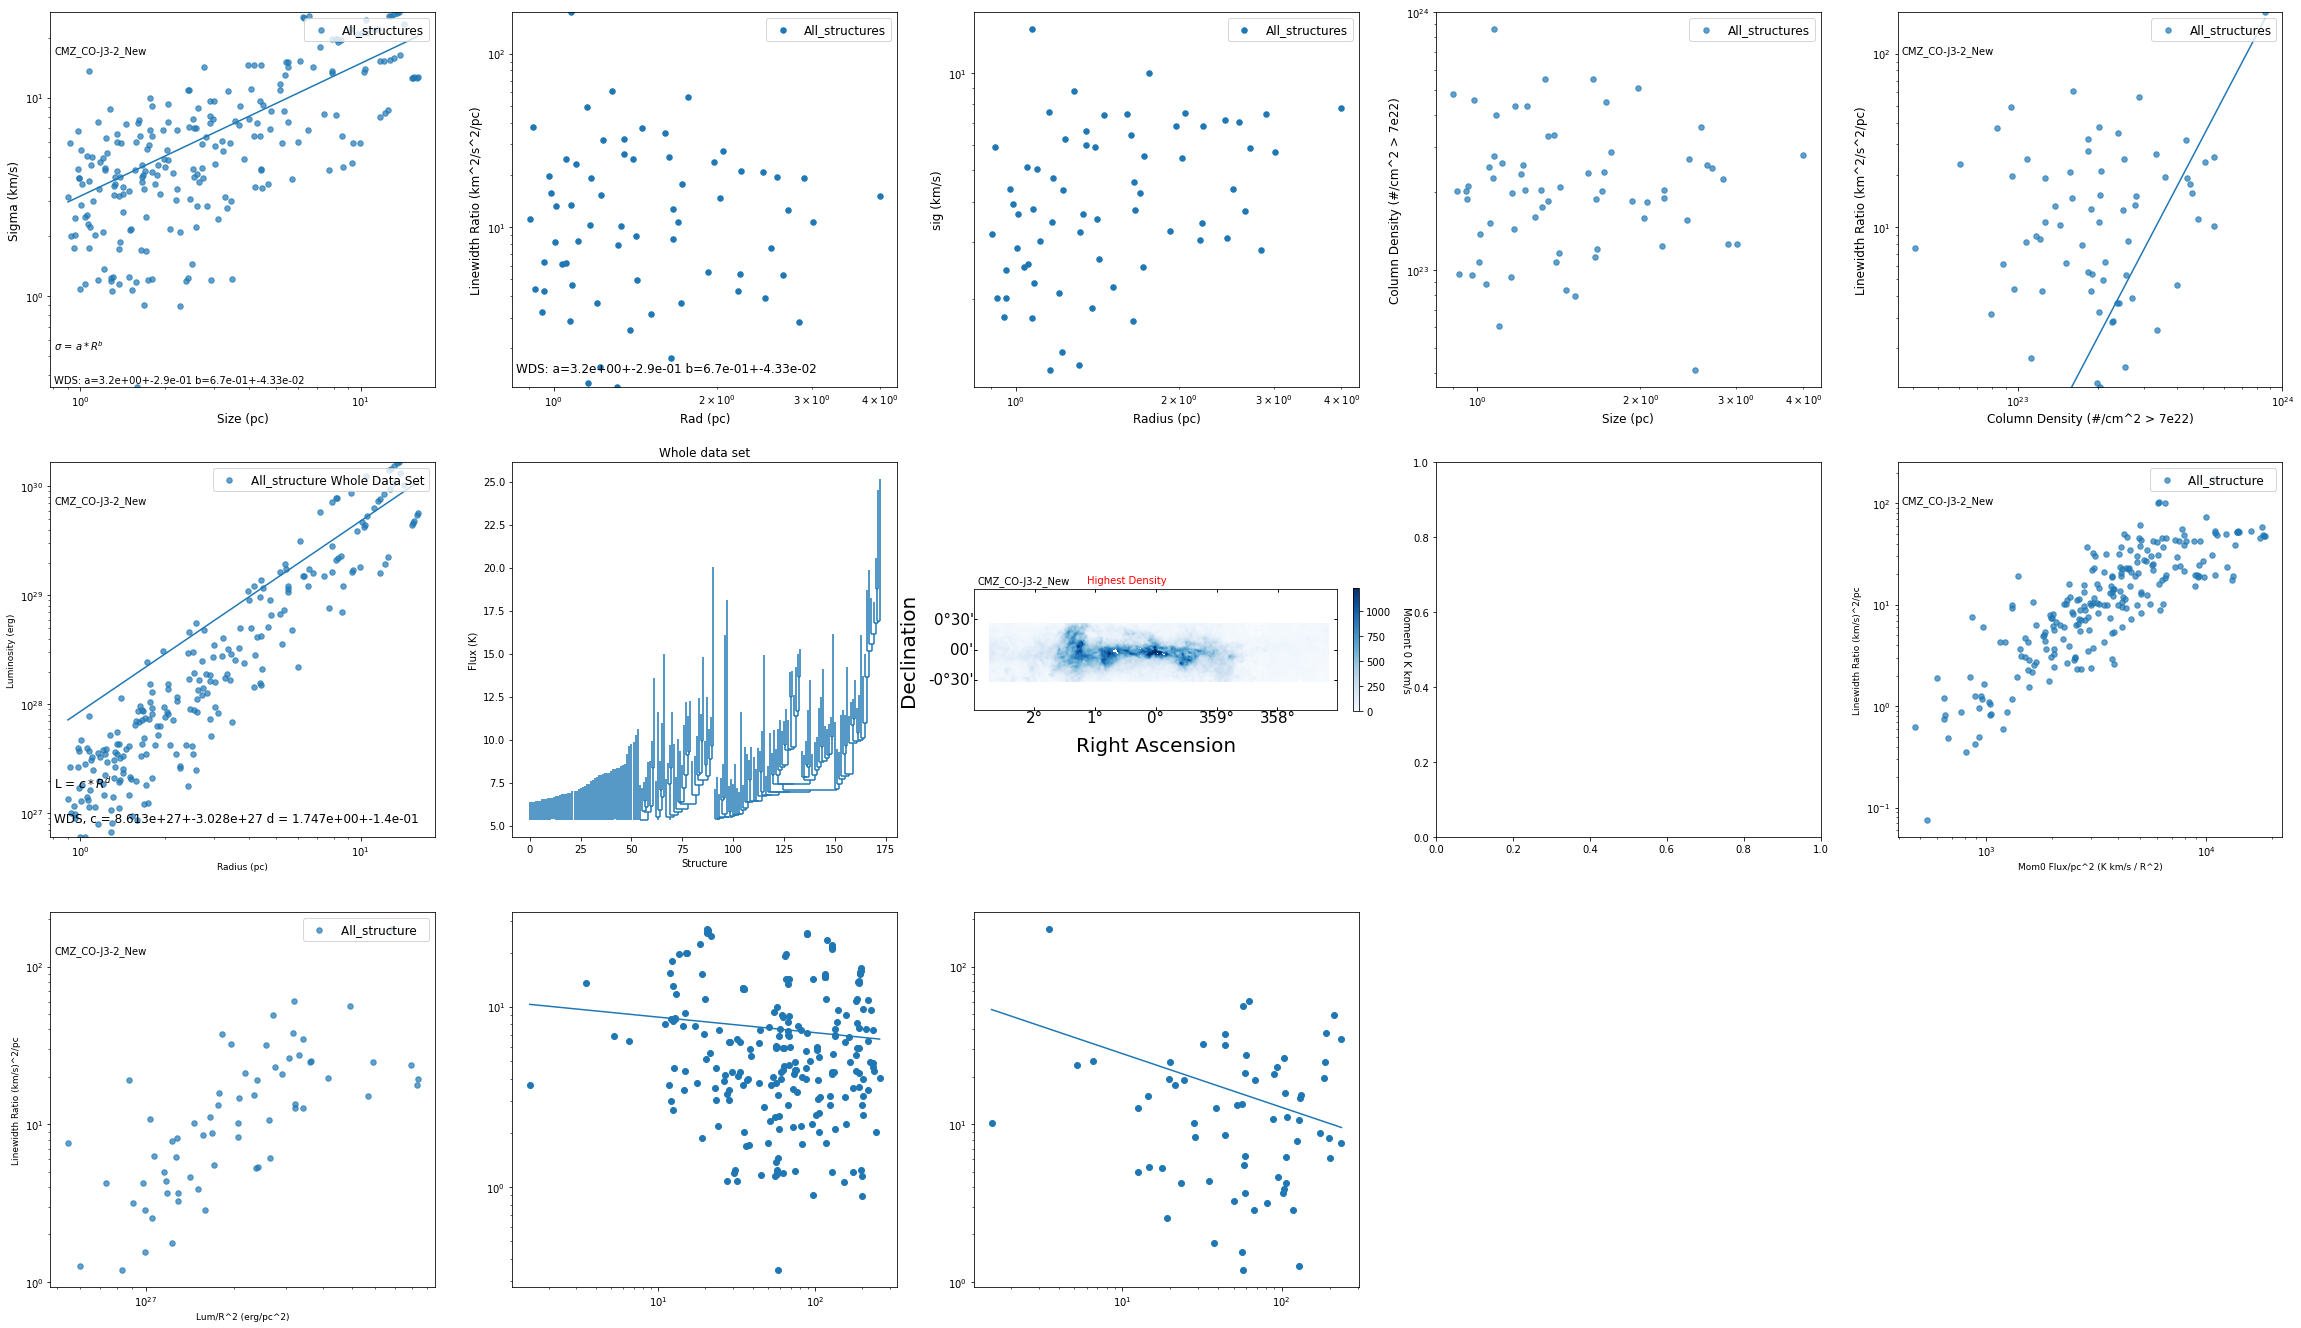

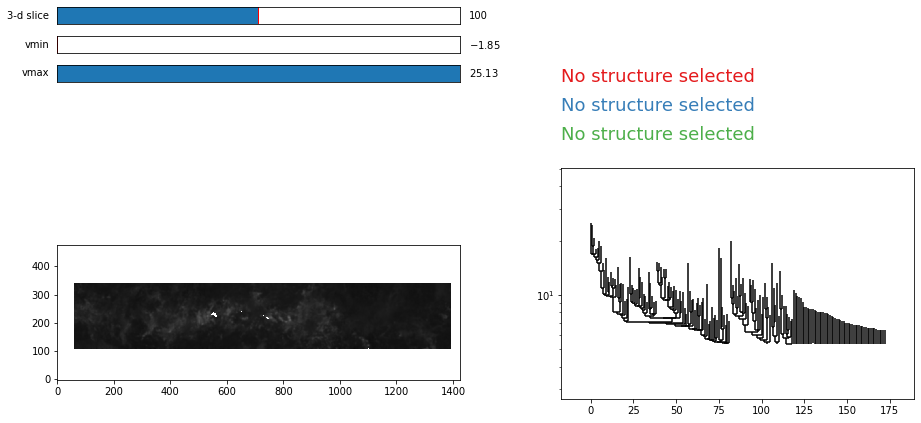

[148. 178.]


In [5]:


#CO 
#
#
#For the cube that has not been rotated
#
#
Num=4
Ram_Limiter=1#What percent of the cube my ram can handle
#NGCCO32_Noise = 0.115*u.K
NGCCO32_Noise=0.6411655169449448*u.K

LineN="CMZ_CO-J3-2_New"
Name = "CMZ_CO 3-2_Abs_New"
name = "CMZ_CO_3_2_CM_Contours_Abs2_New.jpeg"
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2
Abs_Level="No Clusters"
#low cd
try:
    Names= list(np.load("Names_CMZ_New.npy"))
except:
    Names= list(np.load("Names_CMZ.npy"))
Names[Num] = Name
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")

np.save("Names_CMZ_New",Names)

print(Name,Names)



#path ="Noise_Matched_CMZ_CO_3_2_355_005_New.fits"#"Noise_Matched_"+'CMZ_CO_3_2_358_002.fits'
path ="CMZ_CO_3_2_355_005_New.fits"#"Noise_Matched_"+'CMZ_CO_3_2_358_002.fits'

#path ='CMZ_CO_3_2_355_005_New.fits'
pathog='CMZ_CO_3_2_355_005_New.fits'
pathCont = 'CMZ_Continuum_Splice.fits'


#Make subcube

Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qp.allow_huge_operations=True
Qp = Qp[:,:,:]#Get rid of the excess nan parts
Q = Qp.to(u.K)#Jy to Kelvin

sc = Q.unmasked_copy()
Qpog = SpectralCube.read(pathog).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qpog.allow_huge_operations=True
Qpog = Qpog[:,:,:]#Get rid of the excess nan parts
Qog = Qpog.to(u.K)#Jy to Kelvin

scog = Qog.unmasked_copy()

del scog
del Qog
del Qpog
scW = sc.wcs[:][:][0]
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scF = scn#[:,50:1300,50:1500]#Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
datn = dat#[:,50:1300,50:1500]#Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)z

#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Do the same thing to the continuum image
scCont.allow_huge_operations=True
scContW = scCont.reproject(scF.moment0().header)
#m=.115


#Put this up here for the column density map
metadata = {}
metadata["distance"] = 8.178*10**-3*u.Mpc
arc_per_pix_yc =  abs(scContW.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scContW.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scContW.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scContW.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratioc']=beam_area_ratioc
pc_per_pixelc = abs(scContW.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc






Continuum_Data  =scContW.hdu.data
scWCS = scF.wcs[:][:][0]

moment_0_sub  = scF.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 



######Moment 0 for both
######and cont
Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)


cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number


rm=moment_0_sub.hdu.data/cSD
rmU = rm*u.K*u.km/u.s#Just put back in the units
rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all

######ratio
   
bp = np.where(cSD<=.1*10**22/u.cm**2)
bp2 = np.where( moment_0_sub.hdu.data < .22)

Continuum_Data[bp] = np.nan


cSD[bp]=np.nan
rmU[bp]=np.nan
rmU[bp2]=np.nan


#Remove dense areas
bp = np.where(cSD>5*10**23/u.cm**2)
print(np.shape(cSD),np.shape(rmU),np.shape(datn))
cSD[bp]=np.nan
rmU[bp]=np.nan
for lmi in range(np.shape(datn)[0]):
    datn[lmi][bp]=np.nan

Non_nan=((datn>0)  | (datn<0 ))

m = (np.nanstd(datn,where= Non_nan)) #Noise K

print("Noise (No dense gas in the cont): ",m)





Make_Plot("Column Density","(#/cm^2)",cSD,float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
Make_Plot("Column Density","()",scCont.hdu.data,float(np.nanmin(scCont.hdu.data)),float(np.nanmax(scCont.hdu.data)),scCont.wcs,1,1,1,True)
Make_Plot("Column Density","(repo)",scContW.hdu.data,float(np.nanmin(scContW.hdu.data)),float(np.nanmax(scContW.hdu.data)),scContW.wcs,1,1,1,True)


Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)





header = scF.hdu.header
print()
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(1,freq,metadata['wavelength'])
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =scF[0][0][0].unit# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*(8.178*10**-3))**2#mpc^2/pix^2
print(area_res,type(area_res))

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s

metadata["vaxis"]=0
metadata["wcsu"]=scF.wcs

d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value) #The main culprit
#d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value*3) #The main culprit



vel,RA,Dec = scF.world[:,0,0]
Rads,Sigmas,CD,Lumin,SIDS,MOM0FLUX,Distances = Dendro_Arrays(d,datn,vel,Continuum_Data,metadata)
print(np.shape(Rads[0]),'rads')
print(np.shape(Sigmas[0]),"sigs")
print(np.shape(Rads[1]),'rads')
print(np.shape(Sigmas[1]),"sigs")
##Analyze dendograms





fig = plt.figure(1,figsize=(40,40))


axAlpha = pylab.subplot(5, 5, 7)
axBeta = pylab.subplot(5, 5, 8)
axGamma = pylab.subplot(5, 5, 9)
axDelta = pylab.subplot(5, 5, 10)




p1=d.plotter()
p1.plot_tree(axAlpha)
axAlpha.set_xlabel("Structure")
axAlpha.set_ylabel("Flux (K)")
axAlpha.set_title("Whole data set")



#Plot contours for the top ten clusters


#scCropped =scF.moment0().hdu.data
scCropped =scF.moment0().hdu.data
scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan
print(np.nanmean(np.nanstd(scF.moment0().hdu.data))*1)
scCropped[bp]=np.nan
axDelta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
#axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
imBeta = axDelta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



ColumnCon= np.concatenate((CD[0],CD[1]))
SIDScon = np.concatenate((SIDS[0],SIDS[1]))
nth =0# sorted(CD[0])[len(CD[0])-20]

G1 = True

RA = axDelta.coords[0]                                                                  # 
Dec = axDelta.coords[1]

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
axDelta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.05),xycoords="axes fraction",c="black")  
pylab.annotate(s="Highest Density",fontsize=10,xy=(.31,1.05),xycoords="axes fraction",c="red")  

    


pc_per_pixel = abs(header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc

sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]


from scipy.optimize import curve_fit
from scipy.optimize import leastsq

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]


    
Rcon = np.concatenate((Rads[0],Rads[1]))


Scon = np.concatenate((Sigmas[0],Sigmas[1]))
Scon2 = np.concatenate((Sigmas[2],Sigmas[3]))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)









xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)

ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])


LuminCon = np.concatenate((Lumin[0],Lumin[1]))
ColumnCon= np.concatenate((CD[0],CD[1]))

MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
DistancesCon= np.concatenate((Distances[0],Distances[1]))


#Radius Luminosity fit
#Good pixels are places where the luminosity and therefore column density are above zero
gp = np.where(LuminCon>0)
print(np.shape(Rcon),np.shape(LuminCon))
lgp = LuminCon[gp]
radgp = Rcon[gp]*10**6

gp2 = np.where(ColumnCon>0)
cgp = ColumnCon[gp2]
rgp=Scon[gp2]**2/Rcon[gp2]/10**6
dgp=DistancesCon[gp2]
radgpFORRAT = Rcon[gp2]*10**6
siggpFORRAT = Scon[gp2]
lumFORRAT = LuminCon[gp2]
mom0FORRAT = MOM0FLUXcon[gp2]

#print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))
RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
ysRL = func(xsRL,RLpopt[0],RLpopt[1])
#Column density to Size-linewidth
CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)

Dist_popt,Dist_pcov = curve_fit(func, np.array(DistancesCon,dtype='float64') ,np.array(Scon,dtype='float64'),maxfev=9999099,ftol = 10**-10)
Dist_popt2,Dist_pcov2 = curve_fit(func, np.array(dgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,ftol = 10**-10)

xsDist=np.linspace(np.nanmin(DistancesCon),np.nanmax(DistancesCon),50)
xsDist2=np.linspace(np.nanmin(dgp),np.nanmax(dgp),50)
ysDist=func(xsDist,Dist_popt[0],Dist_popt[1])
ysDist2=func(xsDist2,Dist_popt2[0],Dist_popt2[1])


axdis = pylab.subplot(5, 5, 12)
axdis2 = pylab.subplot(5, 5, 13)
axdis.scatter(DistancesCon,Scon)
axdis2.scatter(dgp,rgp)
axdis.plot(xsDist,ysDist)
axdis2.plot(xsDist2,ysDist2)
axdis2.set_yscale('log')
axdis2.set_xscale('log')
axdis.set_yscale('log')
axdis.set_xscale('log')

xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
ysCD = func(xsCD,CDpopt[0],CDpopt[1])


print(poptCon,pcovCon,"Size Linewidth All_structures:")
print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))


print(RLpopt,RLpcov,"Radius to Luminosity:")
print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))



print(CDpopt,CDpcov,"Column Density to linewidth^2/size:")
print("e = ",CDpopt[0],"+-",np.sqrt(CDpcov[0][0]))
print("f = ",CDpopt[1],"+-",np.sqrt(CDpcov[1][1]))



ax2 = pylab.subplot(5, 5, 1)
ax3 = pylab.subplot(5, 5, 2)
ax4 = pylab.subplot(5, 5, 3)

xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)


p = ax2.plot(xs,ysCon)





st="WDS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")

ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax2.set_xlabel("Size (pc)",fontsize=12)
ax2.set_ylabel("Sigma (km/s)",fontsize=12)
ax2.legend(prop={'size': 12},loc="upper right")
ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#gp = np.where(FRs>0)







xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)




ax4.set_yscale('log')
ax4.set_xscale('log')

ax4.set_xlabel("Radius (pc)",fontsize=12)
ax4.set_ylabel("sig (km/s)",fontsize=12)
ax4.legend(prop={'size': 12},loc="upper right")






xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)

ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax3.set_xlabel("Rad (pc)",fontsize=12)
ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax3.legend(prop={'size': 12})

gp3 = np.where(lumFORRAT>0)
lumFORRAT = lumFORRAT[gp3]
rgpFORRAT = rgp[gp3]
mom0FORRAT = mom0FORRAT[gp3]



ax5 = pylab.subplot(5, 5, 4)
ax6 = pylab.subplot(5, 5, 5)
ax7 = pylab.subplot(5, 5, 6)



xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures",s=30,alpha=.7)
ax5.set_yscale('log')
ax5.set_xscale('log')
ax5.set_xlabel("Size (pc)",fontsize=12)
ax5.set_ylabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
ax5.legend(prop={'size': 12},loc="upper right")




xspF2 = ax6.scatter(cgp,rgp,label="All_structures",s=30,alpha=.7)
pF2 = ax6.plot(xsCD,ysCD)

ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax6.set_xlabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax6.legend(prop={'size': 12},loc="upper right")
ax6.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
pFLLu2 = ax7.plot(xsRL,ysRL)

st = "WDS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.13),xycoords="axes fraction")
ax7.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")

ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax7.set_xlabel("Radius (pc)",fontsize=9)
ax7.set_ylabel("Luminosity (erg)",fontsize=9)
ax7.legend(prop={'size': 12},loc="upper right")
ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


axLam = pylab.subplot(5, 5, 11)
lum_rat = axLam.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axLam.set_yscale('log')
axLam.set_xscale('log')
axLam.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
axLam.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axLam.legend(prop={'size': 12},loc="upper right")
axLam.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



axDelta = pylab.subplot(5, 5, 10)




gp4=np.where(MOM0FLUXcon>0)
mom0FORFlux=MOM0FLUXcon[gp4]
radgpFORFlux=Rcon[gp4]*10**6
rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6

mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axDelta.set_yscale('log')
axDelta.set_xscale('log')
axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axDelta.legend(prop={'size': 12},loc="upper right")
axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


pylab.show()



NameCol = (Name+"_Column")
NameLum = (Name+"_Luminosities")

NameFlux = (Name+"Flux_Dense_No_Clusters")
NameRFF = (Name+"Rad_For_Flux_No_Clusters")





v1 = d.viewer()
v1.show()

#Must use text because np load is broken
if(Abs_Level=="All"):
    Suffix=''
if(Abs_Level=="None"):
    Suffix='_NA'
if(Abs_Level=="No Clusters"):
    Suffix='_No_Clusters'
np.savetxt(NameCol+"_Leaves"+Suffix, CD[0],fmt='%s')
np.savetxt(NameCol+"_Branches"+Suffix, CD[1],fmt='%s')

np.savetxt(NameLum+"_Leaves"+Suffix, Lumin[0],fmt='%s')
np.savetxt(NameLum+"_Branches"+Suffix, Lumin[1],fmt='%s')
np.savetxt(NameS+"_Leaves"+Suffix, Sigmas[0],fmt='%s')
np.savetxt(NameS+"_Branches"+Suffix, Sigmas[1],fmt='%s')
np.savetxt(NameR+"_Leaves"+Suffix, Rads[0],fmt='%s')
np.savetxt(NameR+"_Branches"+Suffix, Rads[1],fmt='%s')


np.savetxt(NameFlux+"_Leaves"+Suffix, MOM0FLUX[0],fmt='%s')
np.savetxt(NameFlux+"_Branches"+Suffix, MOM0FLUX[1],fmt='%s')



np.savetxt(NameCol+"_Leaves"+Suffix, CD[0],fmt='%s')
np.savetxt(NameCol+"_Branches"+Suffix, CD[1],fmt='%s')

np.savetxt(NameLum+"_Leaves"+Suffix, Lumin[0],fmt='%s')
np.savetxt(NameLum+"_Branches"+Suffix, Lumin[1],fmt='%s')
np.savetxt(NameS+"_Leaves"+Suffix, Sigmas[0],fmt='%s')
np.savetxt(NameS+"_Branches"+Suffix, Sigmas[1],fmt='%s')
np.savetxt(NameR+"_Leaves"+Suffix, Rads[0],fmt='%s')
np.savetxt(NameR+"_Branches"+Suffix, Rads[1],fmt='%s')
np.savetxt(Name+"Distances_Leaves"+Suffix, Distances[0],fmt='%s')
np.savetxt(Name+"Distances_Branches"+Suffix, Distances[1],fmt='%s')




SIDS=np.concatenate((SIDS[0],SIDS[1]))

print(SIDS[len(SIDS)-3:len(SIDS)-1])
